# Trabajo Práctico 2: Análisis con Árbol de Decisión - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba


## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [3]:
from sklearn.tree import DecisionTreeClassifier

In [4]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import aplicar_one_hot_encoding

In [5]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [6]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [7]:
X, y = dividir_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros, que son 'min_samples','criterio', y 'profundidad', mediante la siguiente función de búsqueda, que utiliza Stratified K-folds cross validation para comparar cada combinación y así obtener la mejor. Nos quedamos con la combinación cuya media de los k-folds(5) tenga la mejor métrica. La métrica de comparación utilizada es AUC-ROC.

In [8]:
def definir_mejores_hiperparametros(X, y):    
    metrics = []
    y_array=np.array(y)    
    for criterio in ['gini','entropy']:
        for profundidad_maxima in [1,2,3,4,5,6,7,8,9,10,15,20,25]:
            for min_samples in [0.075, 0.1, 0.15, 0.2]:
                kf = StratifiedKFold(n_splits=5)
                metricas_de_la_combinacion = []
                for fold_index, (train_index, test_index) in enumerate(kf.split(X, y_array)):
                    arbol = DecisionTreeClassifier(criterion = criterio, max_depth = profundidad_maxima, min_samples_leaf = min_samples)
                    arbol.fit(X.iloc[train_index], y.iloc[train_index])
                    y_pred_proba = arbol.predict_proba(X.iloc[test_index])[:, 1]
                    metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred_proba))

                metrics.append((criterio, profundidad_maxima, min_samples, np.mean(metricas_de_la_combinacion)))
                    
    df_metrics = pd.DataFrame(metrics, columns = ['criterio', 'profundidad_maxima', 'min_samples_leaf', 'rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]
    return mejor_combinacion

## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [9]:
mejor_combinacion = definir_mejores_hiperparametros(X, y)

En caso de que dos o más combinaciones den igual, decidimos quedarnos con la combinación que menor profundidad tenga ya que por la navaja de Ockham es conveniente utilizar el modelo más simple.


In [10]:
mejor_combinacion = mejor_combinacion[mejor_combinacion['profundidad_maxima'] == mejor_combinacion.profundidad_maxima.min()]

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [11]:
parametros_arbol = mejor_combinacion.values[0]
mejor_criterio = parametros_arbol[0]
mejor_profundidad = parametros_arbol[1]
mejor_min_samples_leaf = parametros_arbol[2]
print(f'Mejor criterio: {mejor_criterio}')
print(f'Mejor profundidad máxima: {mejor_profundidad}')
print(f'Mejor mínima cantidad de instancias por hoja: {mejor_min_samples_leaf}')

Mejor criterio: gini
Mejor profundidad máxima: 5
Mejor mínima cantidad de instancias por hoja: 0.075


Entrenamos un árbol de decisión con esa combinación de hiperparámetros.

In [12]:
arbol = DecisionTreeClassifier(criterion = mejor_criterio, max_depth = mejor_profundidad, min_samples_leaf = mejor_min_samples_leaf)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.075)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

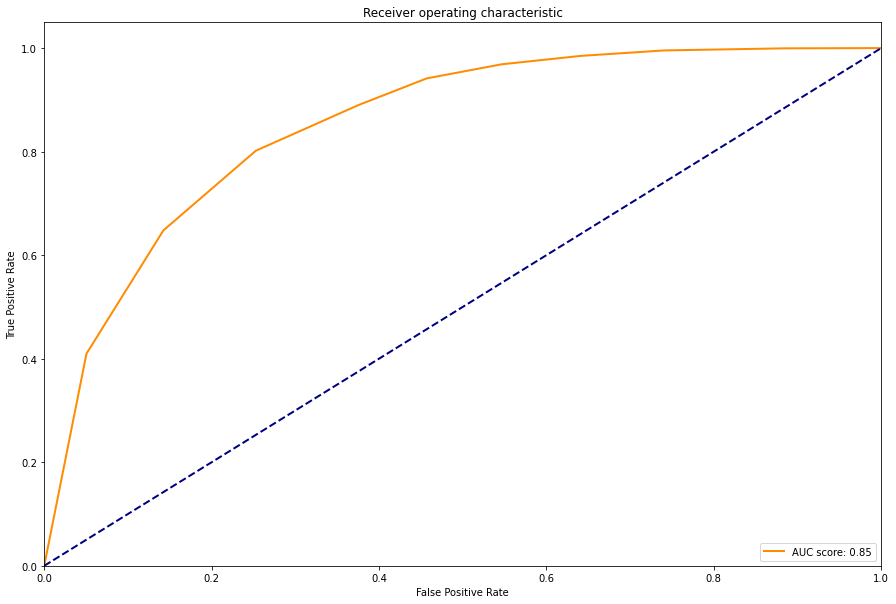

El valor de la metrica AUC-ROC para este modelo es: 0.8527897775875066


In [13]:
y_pred = arbol.predict(X_test)
y_pred_proba = arbol.predict_proba(X_test)[:, 1]
graficar_auc_roc(y_test, y_pred_proba)

Podemos observar que dio un valor bastante alto, lo que es interesante, pues en esta métrica 1 significa un clasificador ideal.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [14]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.833     0.950     0.888      6159
   Tiene Alto Valor Adquisitivo      0.723     0.410     0.523      1982

                       accuracy                          0.818      8141
                      macro avg      0.778     0.680     0.705      8141
                   weighted avg      0.806     0.818     0.799      8141



Por último, mostramos la matriz de confusión correspondiente:

In [15]:
from funciones_auxiliares import graficar_matriz_confusion

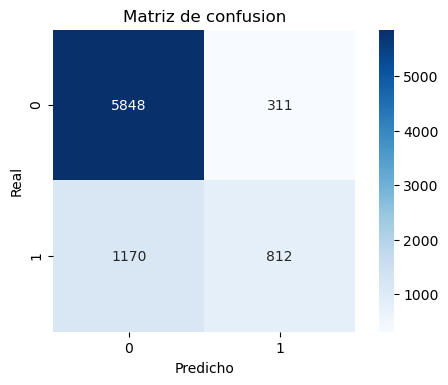

In [16]:
graficar_matriz_confusion(y_test, y_pred)

Podemos ver que el árbol de decisión clasifica bastante bien las instancias que no tienen alto valor adquisitivo, pero no clasificó tan bien las que tienen alto valor adquisitivo. Esto se puede observar en el bajo valor de recall.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [17]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [18]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [19]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp, y)
mejor_combinacion = mejor_combinacion[mejor_combinacion['profundidad_maxima'] == mejor_combinacion.profundidad_maxima.min()]

A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [20]:
parametros_arbol = mejor_combinacion.loc[:].values[0]
mejor_criterio = parametros_arbol[0]
mejor_profundidad = parametros_arbol[1]
mejor_min_samples_leaf = parametros_arbol[2]
print(f'Mejor criterio: {mejor_criterio}')
print(f'Mejor profundidad máxima: {mejor_profundidad}')
print(f'Mejor mínima cantidad de instancias por hoja: {mejor_min_samples_leaf}')

Mejor criterio: gini
Mejor profundidad máxima: 5
Mejor mínima cantidad de instancias por hoja: 0.075


Entrenamos un árbol de decisión con dicha combinación.

In [21]:
arbol_expandido = DecisionTreeClassifier(criterion = mejor_criterio, max_depth = mejor_profundidad, min_samples_leaf = mejor_min_samples_leaf)
arbol_expandido.fit(X_exp_train, y_exp_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.075)

Y ahora hacemos que prediga sobre el dataset expandido. Graficamos también la curva ROC con su respectivo resultado en la métrica AUC-ROC.

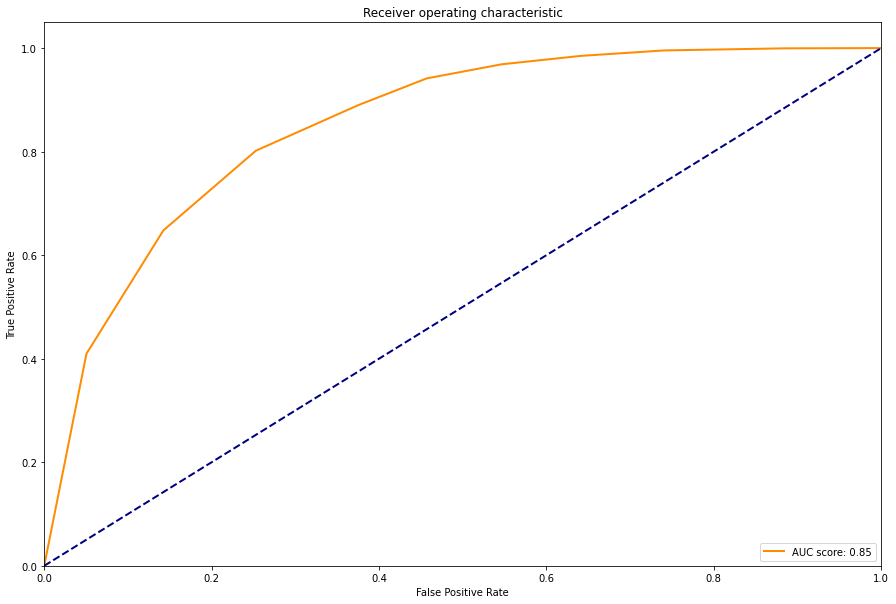

El valor de la metrica AUC-ROC para este modelo es: 0.8527897775875066


In [22]:
y_pred = arbol_expandido.predict(X_exp_test)
y_pred_proba = arbol_expandido.predict_proba(X_exp_test)[:, 1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos observar que el score de AUC-ROC dio exactamente igual al del dataset original. Lo cual puede tener sentido, ya que estas variables pueden no haberle interesado al árbol para tomar decisiones.

Mostramos el classification report:

In [23]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.833     0.950     0.888      6159
   Tiene Alto Valor Adquisitivo      0.723     0.410     0.523      1982

                       accuracy                          0.818      8141
                      macro avg      0.778     0.680     0.705      8141
                   weighted avg      0.806     0.818     0.799      8141



Por último, mostramos la matriz de confusión correspondiente:

In [24]:
from funciones_auxiliares import graficar_matriz_confusion

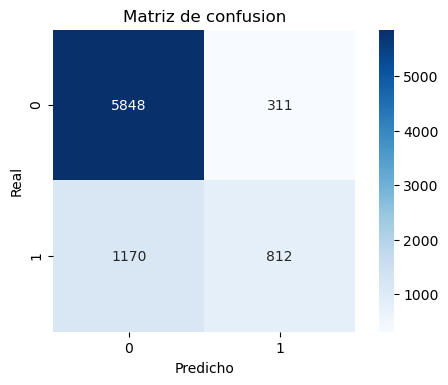

In [25]:
graficar_matriz_confusion(y_exp_test, y_pred)

Podemos ver que el árbol de decisión clasifica bastante bien las instancias que no tienen alto valor adquisitivo, pero no clasificó tan bien las que tienen alto valor adquisitivo.

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con el árbol sin expandir el dataset sobre el dataset de holdout, y la escribimos al archivo 'ArbolDeDecision.csv'

In [26]:
from funciones_auxiliares import traer_holdout
from preprocessing import preparar_holdout
from funciones_auxiliares import escribir_predicciones

In [27]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)
holdout = aplicar_one_hot_encoding(holdout)

In [28]:
predicciones = arbol.predict(holdout)
escribir_predicciones(ids, predicciones, "ArbolDeDecision")